In [1]:
import os
from dataclasses import dataclass
from pathlib import Path

os.chdir(Path("E:\FSDS_NOV\deepCNNclassifier"))

@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list

@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [2]:
from deepClassifier.constants import *
from deepClassifier.utils import read_yaml, create_directories
import tensorflow as tf

In [3]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)

        
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callbacks_config = PrepareCallbacksConfig(
            root_dir = Path(config.root_dir),
            tensorboard_root_log_dir = Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath = Path(config.checkpoint_model_filepath)
        )

        return prepare_callbacks_config

    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir,"PetImages")

        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir = Path(training.root_dir),
            trained_model_path = Path(training.trained_model_path),
            updated_base_model_path = Path(prepare_base_model.updated_base_model_path),
            training_data = Path(training_data),
            params_epochs = params.EPOCHS,
            params_batch_size = params.BATCH_SIZE,
            params_is_augmentation = params.AUGMENTATION,
            params_image_size = params.IMAGE_SIZE
        )

        return training_config

In [4]:
import os
import urllib.request as request
import tensorflow as tf
import time

class Training:
    def __init__(self,config:TrainingConfig):
        self.config = config

    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )

    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split = 0.20
        )

        dataflow_kwargs = dict(
            target_size = self.config.params_image_size[:-1],
            batch_size = self.config.params_batch_size,
            interpolation = "bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory = self.config.training_data,
            subset='validation',
            shuffle = False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range = 40,
                horizontal_flip = True,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                shear_range = 0.2,
                zoom_range = 0.2,
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator

        self.train_generator = train_datagenerator.flow_from_directory(
            directory = self.config.training_data,
            subset = 'training',
            shuffle = True,
            **dataflow_kwargs
        )

    @staticmethod
    def save_model(path:Path,model:tf.keras.Model):
        model.save(path)

    def train(self,callback_list:list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        self.model.fit(
            self.train_generator,
            epochs = self.config.params_epochs,
            steps_per_epoch = self.steps_per_epoch,
            validation_steps = self.validation_steps,
            validation_data = self.valid_generator,
            callbacks = callback_list
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )
    

    

In [5]:
import os
import urllib.request as request
import tensorflow as tf
import time

class PrepareCallbacks:
    def __init__(self,config:PrepareCallbacksConfig):
        self.config = config

    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}"
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)

    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=self.config.checkpoint_model_filepath,
            save_best_only=True
        )
    
    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]

In [6]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallbacks(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()


    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(
        callback_list = callback_list
    )
except Exception as e:
    raise e

[2022-10-23 17:48:17,010: INFO: common]: yaml file: configs\config.yaml loaded successfully
[2022-10-23 17:48:17,018: INFO: common]: yaml file: params.yaml loaded successfully
[2022-10-23 17:48:17,022: INFO: common]: created directory at: artifacts
[2022-10-23 17:48:17,027: INFO: common]: created directory at: artifacts\prepare_callbacks\checkpoint_dir
[2022-10-23 17:48:17,032: INFO: common]: created directory at: artifacts\prepare_callbacks\tensorboard_log_dir
[2022-10-23 17:48:17,036: INFO: common]: created directory at: artifacts\training
Found 4998 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
 212/1250 [====>.........................] - ETA: 1:00:33 - loss: 13.1776 - accuracy: 0.5416

e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


 479/1250 [==========>...................] - ETA: 49:33 - loss: 9.0953 - accuracy: 0.6216

KeyboardInterrupt: 

In [3]:
import os
os.getcwd()

'e:\\FSDS_NOV\\deepCNNclassifier\\research'

In [6]:
import tensorflow as tf
import numpy as np

In [19]:
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model("../artifacts/training/model.h5")
from PIL import Image
img = Image.open("../artifacts/data_ingestion/PetImages/Cat/0.jpg")
img = img.resize((224,224))
img = np.expand_dims(np.array(img),axis=0)
result = model.predict(img)
argmax_index = np.argmax(result,axis=1)
if argmax_index[0] == 0:
    print("predicted: cat")
else:
    print("predicted: dog")

UnimplementedError: Graph execution error:

Detected at node 'model/block1_conv1/Relu' defined at (most recent call last):
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Najam\AppData\Local\Temp\ipykernel_15564\1530315920.py", line 6, in <module>
      model.predict(img)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "e:\FSDS_NOV\deepCNNclassifier\env\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/block1_conv1/Relu'
DNN library is not found.
	 [[{{node model/block1_conv1/Relu}}]] [Op:__inference_predict_function_3673]

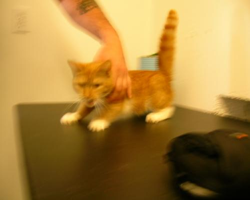

In [17]:
img.resize((250,200))

In [7]:
np.array(img).shape

(224, 224, 3)

In [10]:
img.shape

(1, 224, 224, 3)